In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers
import tensorflow_hub as hub
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

In [ ]:
!pip install kaggle

In [ ]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle (2).json


{'kaggle.json': b'{"username":"richlukich","key":"0acae6c503a810f42cada4da397984d4"}'}

In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

In [ ]:

!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle competitions download -c nlp-getting-started

train.csv: Skipping, found more recently modified local copy (use --force to force download)
test.csv: Skipping, found more recently modified local copy (use --force to force download)
sample_submission.csv: Skipping, found more recently modified local copy (use --force to force download)


In [ ]:
df_train=pd.read_csv('/content/train.csv',index_col='id')

In [ ]:
df_train

,keyword,location,text,target
id,,,,
1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1
...,...,...,...,...
10869,NaN,NaN,Two giant cranes holding a bridge collapse int...,1
10870,NaN,NaN,@aria_ahrary @TheTawniest The out of control w...,1
10871,NaN,NaN,M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...,1


In [ ]:
df=df_train.drop(['location','keyword'],axis=1)

In [ ]:
df.head()

,text,target
id,,
1,Our Deeds are the Reason of this #earthquake M...,1
4,Forest fire near La Ronge Sask. Canada,1
5,All residents asked to 'shelter in place' are ...,1
6,"13,000 people receive #wildfires evacuation or...",1
7,Just got sent this photo from Ruby #Alaska as ...,1


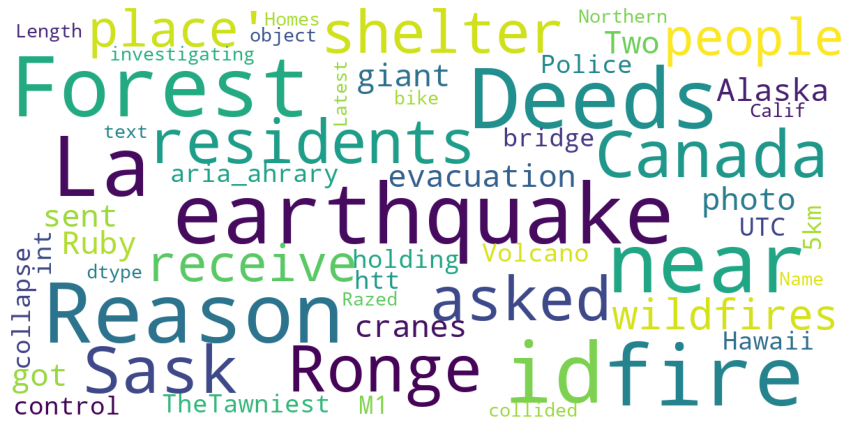

In [ ]:
from wordcloud import WordCloud, STOPWORDS
stopwords = set(STOPWORDS)

def show_wordcloud(data, title = None):
    wordcloud = WordCloud(
        background_color='white',
        stopwords=stopwords,
        max_words=200,
        max_font_size=40, 
        scale=3,
        random_state=1 
).generate(str(data))

    fig = plt.figure(1, figsize=(15, 15))
    plt.axis('off')
    if title: 
        fig.suptitle(title, fontsize=20)
        fig.subplots_adjust(top=2.3)

    plt.imshow(wordcloud)
    plt.show()

show_wordcloud(df['text'])

In [ ]:
def decontracted(text):
    text = re.sub(r"won\'t", "will not", text)
    text = re.sub(r"can\'t", "can not", text)
    text = re.sub(r"n\'t", " not", text)
    text = re.sub(r"\'re", " are", text)
    text = re.sub(r"\'s", " is", text)
    text = re.sub(r"\'d", " would", text)
    text = re.sub(r"\'ll", " will", text)
    text = re.sub(r"\'t", " not", text)
    text = re.sub(r"\'ve", " have", text)
    text = re.sub(r"\'m", " am", text)
    return text

In [ ]:
def remove_stop_words(text):
    #dict containing english stop words
    stop_words = {'ourselves', 'hers', 'between', 'yourself', 'but', 'again', 'there', 'about', 'once',
               'during', 'out', 'very', 'having', 'with', 'they', 'own', 'an', 'be', 'some', 
                'for', 'do', 'its', 'yours', 'such', 'into', 'of', 'most', 'itself', 'other', 
                'off', 'is', 's', 'am', 'or', 'who', 'as', 'from', 'him', 'each',
                'the', 'themselves', 'until', 'below', 'are', 'we', 'these', 'your', 'his', 'through', 
                'don', 'nor', 'me', 'were', 'her', 'more', 'himself', 'this', 'down', 'should', 'our', 
                'their', 'while', 'above', 'both', 'up', 'to', 'ours', 'had', 'she', 'all', 'no', 
                'when', 'at', 'any', 'before', 'them', 'same', 'and', 'been', 'have', 'in', 
                'will', 'on', 'does', 'yourselves', 'then', 'that', 'because', 'what', 'over', 'why', 
                'so', 'can', 'did', 'not', 'now', 'under', 'he', 'you', 'herself', 'has', 'just', 
                'where', 'too', 'only', 'myself', 'which', 'those', 'i', 'after', 'few', 'whom', 't', 
                'being', 'if', 'theirs', 'my', 'against', 'a', 'by', 'doing', 'it', 'how', 'further',
                'was', 'here', 'than'}
  
  #we need to get rid of some special characters
    text = re.sub(r"\x89Û_", "", text)
    text = re.sub(r"\x89ÛÒ", "", text)
    text = re.sub(r"\x89ÛÓ", "", text)

  #convert all the text to lowercase
    text = text.lower()
    sentence_list = text.split()
    new_sentence = []


  
    for word in sentence_list:
        for stop_word in stop_words:
            if (stop_word == word):
                word = re.sub(stop_word, '', word)
        new_sentence.append(word) 
    return (" ".join(new_sentence))

In [ ]:
def remove_punctuation(text):
    #replace every punctuation with a whitespace to keep the words correct
    text = re.sub(r'[^\w\s]',' ',text)
    #remove the successive whitespaces
    _RE_COMBINE_WHITESPACE = re.compile(r"\s+")
    no_punc = _RE_COMBINE_WHITESPACE.sub(" ", text).strip()
    return no_punc

In [ ]:
#this function removes emojis 
#as well as emoticons (representation of a human facial expression using only keyboard characters :D )
#Installing emot library
!pip install emot
#Importing libraries
import re
from emot.emo_unicode import UNICODE_EMO, EMOTICONS

def remove_emojis(text):
    sentence = text.split()
    new_sentence = []
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    emoticon_pattern = re.compile(u'(' + u'|'.join(k for k in EMOTICONS) + u')')

    #since we have an emoticon ":/" as substing in any url, we need to prevent replacing it 
    url_keep_pattern = re.compile("https?://")
  
    for w in sentence :
        w = emoji_pattern.sub(r'', w)
        if (url_keep_pattern.match(w) is None): #if it's not a url
            w = emoticon_pattern.sub(r'', w)
        new_sentence.append(w)
  
  
    return (" ".join(new_sentence))

In [ ]:
def remove_html_tags(text):
    clean = re.compile('<.*?>')
    text = re.sub(clean, '', text)
    return text

In [ ]:
def remove_urls (text):
    text = re.sub(r'''(?i)\b((?:https?://|www\d{0,3}[.]|[a-z0-9.\-]+[.][a-z]{2,4}/)(?:[^\s()<>]+|\(([^\s()<>]+|(\([^\s()<>]+\)))*\))+(?:\(([^\s()<>]+|(\([^\s()<>]+\)))*\)|[^\s`!()\[\]{};:'".,<>?«»“”‘’]))''', '', text)
    return text

In [ ]:
abbreviations = {
    "$" : " dollar ",
    "€" : " euro ",
    "4ao" : "for adults only",
    "a.m" : "before midday",
    "a3" : "anytime anywhere anyplace",
    "aamof" : "as a matter of fact",
    "acct" : "account",
    "adih" : "another day in hell",
    "afaic" : "as far as i am concerned",
    "afaict" : "as far as i can tell",
    "afaik" : "as far as i know",
    "afair" : "as far as i remember",
    "afk" : "away from keyboard",
    "app" : "application",
    "approx" : "approximately",
    "apps" : "applications",
    "asap" : "as soon as possible",
    "asl" : "age, sex, location",
    "atk" : "at the keyboard",
    "ave." : "avenue",
    "aymm" : "are you my mother",
    "ayor" : "at your own risk", 
    "b&b" : "bed and breakfast",
    "b+b" : "bed and breakfast",
    "b.c" : "before christ",
    "b2b" : "business to business",
    "b2c" : "business to customer",
    "b4" : "before",
    "b4n" : "bye for now",
    "b@u" : "back at you",
    "bae" : "before anyone else",
    "bak" : "back at keyboard",
    "bbbg" : "bye bye be good",
    "bbc" : "british broadcasting corporation",
    "bbias" : "be back in a second",
    "bbl" : "be back later",
    "bbs" : "be back soon",
    "be4" : "before",
    "bfn" : "bye for now",
    "blvd" : "boulevard",
    "bout" : "about",
    "brb" : "be right back",
    "bros" : "brothers",
    "brt" : "be right there",
    "bsaaw" : "big smile and a wink",
    "btw" : "by the way",
    "bwl" : "bursting with laughter",
    "c/o" : "care of",
    "cet" : "central european time",
    "cf" : "compare",
    "cia" : "central intelligence agency",
    "csl" : "can not stop laughing",
    "cu" : "see you",
    "cul8r" : "see you later",
    "cv" : "curriculum vitae",
    "cwot" : "complete waste of time",
    "cya" : "see you",
    "cyt" : "see you tomorrow",
    "dae" : "does anyone else",
    "dbmib" : "do not bother me i am busy",
    "diy" : "do it yourself",
    "dm" : "direct message",
    "dwh" : "during work hours",
    "e123" : "easy as one two three",
    "eet" : "eastern european time",
    "eg" : "example",
    "embm" : "early morning business meeting",
    "encl" : "enclosed",
    "encl." : "enclosed",
    "etc" : "and so on",
    "faq" : "frequently asked questions",
    "fawc" : "for anyone who cares",
    "fb" : "facebook",
    "fc" : "fingers crossed",
    "fig" : "figure",
    "fimh" : "forever in my heart", 
    "ft." : "feet",
    "ft" : "featuring",
    "ftl" : "for the loss",
    "ftw" : "for the win",
    "fwiw" : "for what it is worth",
    "fyi" : "for your information",
    "g9" : "genius",
    "gahoy" : "get a hold of yourself",
    "gal" : "get a life",
    "gcse" : "general certificate of secondary education",
    "gfn" : "gone for now",
    "gg" : "good game",
    "gl" : "good luck",
    "gmt" : "greenwich mean time",
    "gmta" : "great minds think alike",
    "gn" : "good night",
    "g.o.a.t" : "greatest of all time",
    "goat" : "greatest of all time",
    "goi" : "get over it",
    "gps" : "global positioning system",
    "gr8" : "great",
    "gratz" : "congratulations",
    "gyal" : "girl",
    "h&c" : "hot and cold",
    "hp" : "horsepower",
    "hr" : "hour",
    "hrh" : "his royal highness",
    "ht" : "height",
    "ibrb" : "i will be right back",
    "ic" : "i see",
    "icq" : "i seek you",
    "icymi" : "in case you missed it",
    "idc" : "i do not care",
    "idgadf" : "i do not give a damn fuck",
    "idgaf" : "i do not give a fuck",
    "idk" : "i do not know",
    "ie" : "that is",
    "i.e" : "that is",
    "ifyp" : "i feel your pain",
    "IG" : "instagram",
    "iirc" : "if i remember correctly",
    "ilu" : "i love you",
    "ily" : "i love you",
    "imho" : "in my humble opinion",
    "imo" : "in my opinion",
    "imu" : "i miss you",
    "iow" : "in other words",
    "irl" : "in real life",
    "j4f" : "just for fun",
    "jic" : "just in case",
    "jk" : "just kidding",
    "jsyk" : "just so you know",
    "l8r" : "later",
    "lb" : "pound",
    "lbs" : "pounds",
    "ldr" : "long distance relationship",
    "lmao" : "laugh my ass off",
    "lmfao" : "laugh my fucking ass off",
    "lol" : "laughing out loud",
    "ltd" : "limited",
    "ltns" : "long time no see",
    "m8" : "mate",
    "mf" : "motherfucker",
    "mfs" : "motherfuckers",
    "mfw" : "my face when",
    "mofo" : "motherfucker",
    "mph" : "miles per hour",
    "mr" : "mister",
    "mrw" : "my reaction when",
    "ms" : "miss",
    "mte" : "my thoughts exactly",
    "nagi" : "not a good idea",
    "nbc" : "national broadcasting company",
    "nbd" : "not big deal",
    "nfs" : "not for sale",
    "ngl" : "not going to lie",
    "nhs" : "national health service",
    "nrn" : "no reply necessary",
    "nsfl" : "not safe for life",
    "nsfw" : "not safe for work",
    "nth" : "nice to have",
    "nvr" : "never",
    "nyc" : "new york city",
    "oc" : "original content",
    "og" : "original",
    "ohp" : "overhead projector",
    "oic" : "oh i see",
    "omdb" : "over my dead body",
    "omg" : "oh my god",
    "omw" : "on my way",
    "p.a" : "per annum",
    "p.m" : "after midday",
    "pm" : "after midday",
    "poc" : "people of color",
    "pov" : "point of view",
    "pp" : "pages",
    "ppl" : "people",
    "prw" : "parents are watching",
    "ps" : "postscript",
    "pt" : "point",
    "ptb" : "please text back",
    "pto" : "please turn over",
    "qpsa" : "what happens", #"que pasa",
    "ratchet" : "rude",
    "rbtl" : "read between the lines",
    "rlrt" : "real life retweet", 
    "rofl" : "rolling on the floor laughing",
    "roflol" : "rolling on the floor laughing out loud",
    "rotflmao" : "rolling on the floor laughing my ass off",
    "rt" : "retweet",
    "ruok" : "are you ok",
    "sfw" : "safe for work",
    "sk8" : "skate",
    "smh" : "shake my head",
    "sq" : "square",
    "srsly" : "seriously", 
    "ssdd" : "same stuff different day",
    "tbh" : "to be honest",
    "tbs" : "tablespooful",
    "tbsp" : "tablespooful",
    "tfw" : "that feeling when",
    "thks" : "thank you",
    "tho" : "though",
    "thx" : "thank you",
    "tia" : "thanks in advance",
    "til" : "today i learned",
    "tl;dr" : "too long i did not read",
    "tldr" : "too long i did not read",
    "tmb" : "tweet me back",
    "tntl" : "trying not to laugh",
    "ttyl" : "talk to you later",
    "u" : "you",
    "u2" : "you too",
    "u4e" : "yours for ever",
    "utc" : "coordinated universal time",
    "w/" : "with",
    "w/o" : "without",
    "w8" : "wait",
    "wassup" : "what is up",
    "wb" : "welcome back",
    "wtf" : "what the fuck",
    "wtg" : "way to go",
    "wtpa" : "where the party at",
    "wuf" : "where are you from",
    "wuzup" : "what is up",
    "wywh" : "wish you were here",
    "yd" : "yard",
    "ygtr" : "you got that right",
    "ynk" : "you never know",
    "zzz" : "sleeping bored and tired"
}

In [ ]:
def fix_slangs(text):
  #first of all we need to change our text to lowercase to match the abbreviations, otherwise some words won't be changed
  #eg: NYC
    text = text.lower()
    sentence_list = text.split()
    new_sentence = []
    
    for word in sentence_list:
        for candidate_replacement in abbreviations:
            if (candidate_replacement == word):
                word = word.replace(candidate_replacement, abbreviations[candidate_replacement])
        new_sentence.append(word) 
  
    return (" ".join(new_sentence))

In [ ]:
def preprocessing (df):
    
    df['text'] = df['text'].apply(decontracted)
    df['text'] = df['text'].apply(remove_stop_words)
    df['text'] = df['text'].apply(remove_emojis)
    df['text'] = df['text'].apply(remove_html_tags)
    df['text'] = df['text'].apply(remove_urls)
    df['text'] = df['text'].apply(remove_punctuation)
    df['text'] = df['text'].apply(fix_slangs)
    
    return df

In [ ]:
df = preprocessing(df)
df.head()

,text,target
id,,
1,deeds reason earthquake may allah forgive us,1
4,forest fire near la ronge sask canada,1
5,residents asked ishelter place notified office...,1
6,13 000 people receive wildfires evacuation ord...,1
7,got sent photo ruby alaska smoke wildfires pou...,1


In [ ]:
df_test=pd.read_csv('/content/test.csv')
test_id=df_test['id'].values
df_test=pd.read_csv('/content/test.csv',index_col='id')
df_T=df_test.drop(['location','keyword'],axis=1)

In [ ]:
df_T.head()

,text
id,
0,Just happened a terrible car crash
2,"Heard about #earthquake is different cities, s..."
3,"there is a forest fire at spot pond, geese are..."
9,Apocalypse lighting. #Spokane #wildfires
11,Typhoon Soudelor kills 28 in China and Taiwan


In [ ]:
df_T = preprocessing(df_T)
df_T.head()

,text
id,
0,happened terrible car crash
2,heard earthquake different cities stay safe ev...
3,forest fire spot pond geese fleeing across str...
9,apocalypse lighting spokane wildfires
11,typhoon soudelor kills 28 china taiwan


In [ ]:
def vocab_maxlen_X_pad(df_train,df_test):
  X_train=df_train['text'].values
  X_test=df_test['text'].values
  total_tweets = np.concatenate((X_train, X_test))

  tokenizer=Tokenizer()
  tokenizer.fit_on_texts(total_tweets)
  vocab_size=len(tokenizer.word_index)+1
  maxlen=max(len(x.split()) for x in total_tweets)
  X_train_token = tokenizer.texts_to_sequences(X_train)
  X_test_token = tokenizer.texts_to_sequences(X_test)
  X_pad_train=pad_sequences(X_train_token,maxlen=maxlen,padding='post')
  X_pad_test=pad_sequences(X_test_token,maxlen=maxlen,padding='post')
  return vocab_size,maxlen,X_pad_train,X_pad_test

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
def tf_idf(df):
  vectorizer = TfidfVectorizer()
  X=vectorizer.fit_transform(df['text'].values)
  return X
X_pad_train=tf_idf(df)

In [ ]:
X_pad_train.shape

(7613, 17023)

In [ ]:
vocab_size,maxlen,X_pad_train,X_pad_test=vocab_maxlen_X_pad(df_train=df,df_test=df_T)
print (vocab_size,maxlen,X_pad_train.shape,X_pad_test.shape)

21389 28 (7613, 28) (3263, 28)


In [ ]:
y=df['target'].values

In [ ]:
y

array([1, 1, 1, ..., 1, 1, 1])

In [ ]:
# Test train split 
X_train, X_test, y_train, y_test = train_test_split(X_pad_train, y, test_size = 0.1, random_state = 42)

In [ ]:
import keras.backend as K
def get_f1(y_true, y_pred): #taken from old keras source code
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val

In [ ]:
import keras
import keras.layers as L
model = tf.keras.Sequential()
model.add(L.Embedding(vocab_size, 100, input_length=maxlen))
model.add(L.Conv1D(filters=32, kernel_size=8, activation='relu'))
model.add(L.MaxPooling1D(pool_size=3))
model.add(L.Dropout(0.3))
#model.add(L.Conv1D(filters=64, kernel_size=8, activation='relu'))
#model.add(L.MaxPooling1D(pool_size=2))
#model.add(L.Dropout(0.3))
model.add(L.Flatten())
model.add(L.Dense(10, activation='relu'))
model.add(L.Dense(1, activation='sigmoid'))
model.summary()

Model: "sequential_35"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_30 (Embedding)     (None, 28, 100)           2138900   
_________________________________________________________________
conv1d_12 (Conv1D)           (None, 21, 32)            25632     
_________________________________________________________________
max_pooling1d_11 (MaxPooling (None, 7, 32)             0         
_________________________________________________________________
dropout_21 (Dropout)         (None, 7, 32)             0         
_________________________________________________________________
flatten_19 (Flatten)         (None, 224)               0         
_________________________________________________________________
dense_54 (Dense)             (None, 10)                2250      
_________________________________________________________________
dense_55 (Dense)             (None, 1)               

In [ ]:
learning_rate=0.0001
model.compile(loss='binary_crossentropy',optimizer=tf.keras.optimizers.Adamax(lr=learning_rate),metrics=[get_f1,'accuracy'])

In [ ]:
history = model.fit(X_train, y_train,
epochs=100,
batch_size=128,
validation_data=(X_test,y_test))

Epoch 1/100
54/54 [==============================] - 2s 28ms/step - loss: 0.6892 - get_f1: 0.1009 - accuracy: 0.5646 - val_loss: 0.6856 - val_get_f1: 0.0000e+00 - val_accuracy: 0.5591
Epoch 2/100
54/54 [==============================] - 1s 24ms/step - loss: 0.6836 - get_f1: 8.2310e-04 - accuracy: 0.5722 - val_loss: 0.6826 - val_get_f1: 0.0000e+00 - val_accuracy: 0.5591
Epoch 3/100
54/54 [==============================] - 1s 24ms/step - loss: 0.6810 - get_f1: 0.0000e+00 - accuracy: 0.5675 - val_loss: 0.6808 - val_get_f1: 0.0000e+00 - val_accuracy: 0.5591
Epoch 4/100
54/54 [==============================] - 1s 24ms/step - loss: 0.6783 - get_f1: 0.0000e+00 - accuracy: 0.5690 - val_loss: 0.6796 - val_get_f1: 0.0000e+00 - val_accuracy: 0.5591
Epoch 5/100
54/54 [==============================] - 1s 24ms/step - loss: 0.6751 - get_f1: 8.2736e-04 - accuracy: 0.5769 - val_loss: 0.6786 - val_get_f1: 0.0000e+00 - val_accuracy: 0.5591
Epoch 6/100
54/54 [==============================] - 1s 23ms/ste

In [ ]:
pred=model.predict_classes(X_pad_test)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


In [ ]:
sub = pd.DataFrame()
sub['Id'] = test_id
sub['target'] = pred

In [ ]:
sub.head()

,Id,target
0,0,1
1,2,1
2,3,1
3,9,1
4,11,1


In [ ]:
sub.to_csv('submission_embedding.csv',index=False)